In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
# Any import of metpy will activate the accessors
import metpy.calc as mpcalc
from metpy.testing import get_test_data
from metpy.units import units
from mpl_toolkits.basemap import Basemap 
import os 
from numpy import ma as MA 

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [2]:
# Open the netCDF file as a xarray Dataset
data = xr.open_dataset('wind_M_200.nc')


# View a summary of the Dataset
print(data)


<xarray.Dataset>
Dimensions:    (latitude: 18, longitude: 45, time: 33604)
Coordinates:
  * longitude  (longitude) float32 -19.5 -18.75 -18.0 -17.25 ... 12.0 12.75 13.5
  * latitude   (latitude) float32 17.25 16.5 15.75 15.0 ... 6.75 6.0 5.25 4.5
  * time       (time) datetime64[ns] 1990-01-01 ... 2012-12-31T21:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.6
    history:      Thu Jan 16 09:43:39 2020: cdo merge Wind_data_u_200.nc Wind...
    CDO:          Climate Data Operators version 1.7.0 (http://mpimet.mpg.de/...


In [3]:
data = data.metpy.parse_cf()
# To rename variables, supply a dictionary between old and new names to the rename method
data = data.rename({
    'u10': 'u',
    'v10': 'v',
})

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


In [4]:
time = data['u'].metpy.time
data_crs = data['u'].metpy.cartopy_crs
print(data_crs)
x, y = data['u'].metpy.coordinates('x', 'y')



In [19]:
data_level = data.metpy.loc[{time.name: time[1]}]

In [6]:
#this line calcs wind direction from data level u and v
D=mpcalc.wind_direction(data_level['u'], data_level['v'])

In [7]:
#this line calcs wind speed from data level u and v
M=mpcalc.wind_speed(data_level['u'], data_level['v'])

In [29]:
#Wind_S=mpcalc.wind_speed(U,V)
#Wind_D=mpcalc.wind_direction(U,V, convention='from')

In [8]:
#this is where the lon and lat are merged into grid format for use in ploting W.speed and W.diretion
lon_2d, lat_2d = np.meshgrid(data['longitude'], data['latitude'])

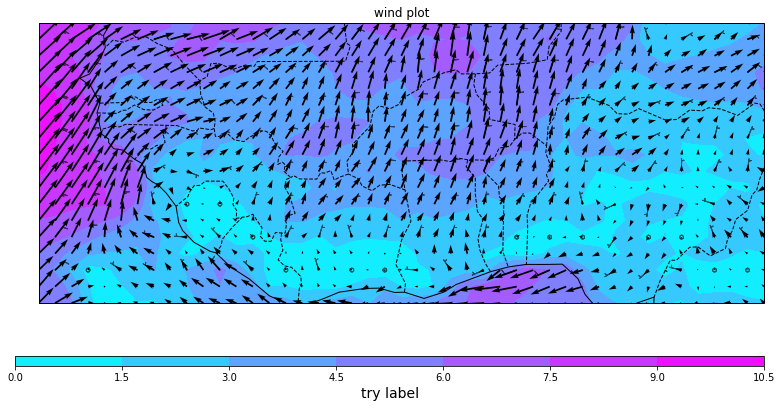

In [20]:
# Create the matplotlib figure and axis
fig, ax = plt.subplots(1, 1, figsize=(13, 7), subplot_kw={'projection': data_crs})

cs=plt.contourf(lon_2d, lat_2d, M, cmap='cool', transform=ccrs.PlateCarree())


ax.barbs( x[wind_slice], y[wind_slice],
         data_level['u'].metpy.unit_array[wind_slice, wind_slice].to('knots'),
         data_level['v'].metpy.unit_array[wind_slice, wind_slice].to('knots'),
         alpha=.6,length=5)
ax.quiver(lon_2d, lat_2d, d1, d2,)

plt.title('wind plot',{"fontsize" : 12})

# Add geographic features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle='--')
cax=fig.add_axes([0.1,0.1,0.8,0.02])
out=fig.colorbar(cs, cax=cax, orientation='horizontal',extend='right')
out.set_label(r'try label', fontsize=14)

In [17]:
#this is where the calculation for the wind direction to draw the arrows according to intensity and direct is made
#NB: the longer the arrow, the more intense the wind
map = Basemap(projection='merc',llcrnrlat=-19.5,urcrnrlat=4.5, llcrnrlon= 17.25,urcrnrlon=13.5,lat_ts=0,resolution='l') 
d1=M*np.sin(D)
d2=M*np.cos(D)
